# Import

In [201]:
import random

import numpy as np
import pandas as pd

from PIL import Image

import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score

import torchvision.transforms as tfs
from torchvision.models import vit_b_16, ViT_B_16_Weights, regnet, efficientnet_b2, resnet50, \
    ResNet50_Weights, convnext_base, ConvNeXt_Base_Weights, regnet_x_16gf, RegNet_X_16GF_Weights
from torchvision.utils import make_grid

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments
from transformers import Trainer

from sklearn.metrics import confusion_matrix

import wandb
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset

from evaluate import load

import csv
import os

# Constants

Dataset is available at the link: https://drive.google.com/file/d/1ImAdVuWzqT5OT40qBxV1tVSoFDEAeeKy/view?usp=sharing

In [2]:
TRAIN = 'D:/woodhack/train/'
VAL = 'D:/woodhack/val/'
TEST = 'D:/woodhack/test/'
LEARNING_RATE = 3e-4
BATCH_SIZE = 16
IMG_SIZE = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
pl.seed_everything(42)

Global seed set to 42


42

# ViT 

## Data 

### Overview

Load train and val datasets from disk 

In [3]:
train_ds = load_dataset("imagefolder", data_dir=TRAIN)
train_ds

Resolving data files:   0%|          | 0/528 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/melik/.cache/huggingface/datasets/imagefolder/default-fa8f3fe944beb9c6/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 528
    })
})

In [4]:
val_ds = load_dataset("imagefolder", data_dir=VAL)
val_ds

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/melik/.cache/huggingface/datasets/imagefolder/default-52cbcd16184219aa/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
})

Look at the examples 

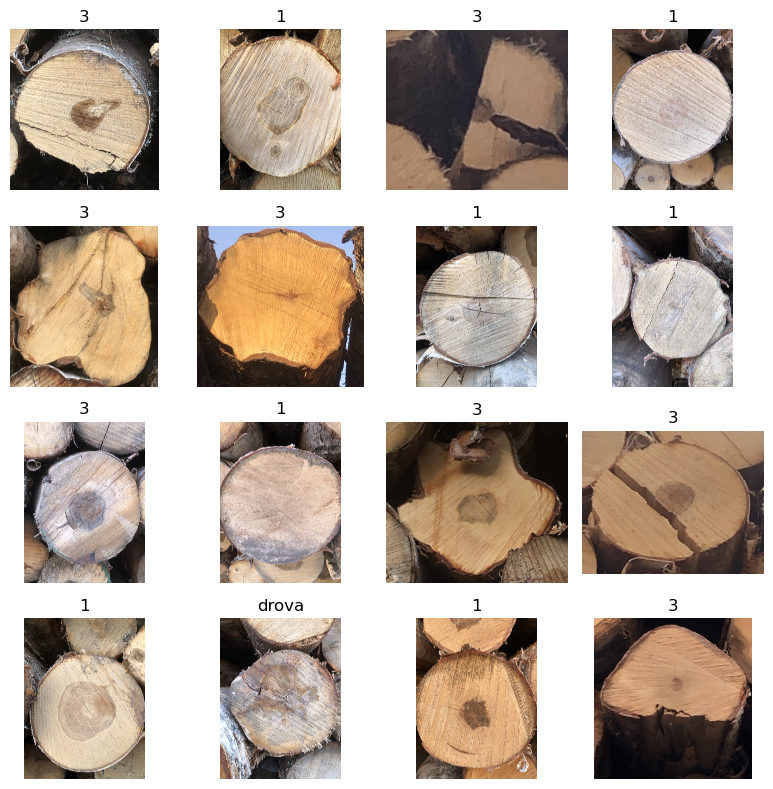

In [6]:
def show_image_grid(dataset, split, grid_size=(4,4)):
    # Select random images from the given split
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]
    
    # Display the images in a grid
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(dataset["train"].features["label"].int2str(labels[i]))
    
    plt.tight_layout()
    plt.show()
    
show_image_grid(train_ds, 'train')

### Preprocess

Prepare datasets for input to model 

In [7]:
def transform(examples):
    inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
    if 'label' in examples.keys():
        inputs["labels"] = examples["label"]
    return inputs

In [11]:
prepared_train_ds = train_ds.with_transform(transform)
prepared_train_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 528
    })
})

In [13]:
prepared_val_ds = val_ds.with_transform(transform)
prepared_val_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
})

In [14]:
def collate_fn(batch):
    # print(batch)
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Metrics

Load metrics and write function to compute them 

In [15]:
# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
    # compute the accuracy and f1 scores & return them
    accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
    f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
    return {**accuracy_score, **f1_score}

## Training

### Model

Download pretrained ViT and modify it for custom dataset  

In [31]:
# the model name
model_name = "google/vit-base-patch16-224"
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = ViTForImageClassification.from_pretrained(model_name)
model.classifier = nn.Linear(in_features=768, out_features=3, bias=True)
model.num_labels = 3

loading configuration file preprocessor_config.json from cache at C:\Users\melik/.cache\huggingface\hub\models--google--vit-base-patch16-224\snapshots\2ddc9d4e473d7ba52128f0df4723e478fa14fb80\preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

loading configuration file config.json from cache at C:\Users\melik/.cache\huggingface\hub\models--google--vit-base-patch16-224\snapshots\2ddc9d4e473d7ba52128f0df4723e478fa14fb80\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "

### Train

In [40]:
training_args = TrainingArguments(
    output_dir="./vit-wood-classification",
    per_device_train_batch_size=8, 
    evaluation_strategy="steps",   
    num_train_epochs=1,             
    eval_steps=11,
    save_steps=11,
    logging_steps=1,
    save_total_limit=2,             
    remove_unused_columns=False,    
    push_to_hub=False,              
    report_to='wandb',        
    load_best_model_at_end=True,
)


PyTorch: setting up devices


In [41]:
trainer = Trainer(
    model=model,                        
    args=training_args,                 
    data_collator=collate_fn,           
    compute_metrics=compute_metrics,    
    train_dataset=prepared_train_ds["train"],     
    eval_dataset=prepared_val_ds["train"], 
    tokenizer=image_processor,
)

In [42]:
train_results = trainer.train()

C:\Users\melik\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 528
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66
  Number of trainable parameters = 85800963
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy,F1
11,0.139900,0.297837,0.900000,0.625000
22,0.518600,0.278983,0.920000,0.852174
33,0.158400,0.191067,0.960000,0.912593
44,0.049200,0.111700,0.980000,0.944974
55,0.013900,0.109532,0.980000,0.985790
66,0.809500,0.111577,0.960000,0.930427


***** Running Evaluation *****
  Num examples = 50
  Batch size = 8
Saving model checkpoint to ./vit-wood-classification\checkpoint-11
Configuration saved in ./vit-wood-classification\checkpoint-11\config.json
Model weights saved in ./vit-wood-classification\checkpoint-11\pytorch_model.bin
Image processor saved in ./vit-wood-classification\checkpoint-11\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 50
  Batch size = 8
Saving model checkpoint to ./vit-wood-classification\checkpoint-22
Configuration saved in ./vit-wood-classification\checkpoint-22\config.json
Model weights saved in ./vit-wood-classification\checkpoint-22\pytorch_model.bin
Image processor saved in ./vit-wood-classification\checkpoint-22\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 50
  Batch size = 8
Saving model checkpoint to ./vit-wood-classification\checkpoint-33
Configuration saved in ./vit-wood-classification\checkpoint-33\config.json
Model weights saved in ./vit

## Confusion matrix 

In [210]:
labels = train_ds['train'].features['label'].names
id2label = {i: c for i, c in enumerate(labels)}
id2label

{0: '1', 1: '3', 2: 'drova'}

In [211]:
y_true = []
y_pred = []
for i in range(len(prepared_val_ds['train'])):
    pixel_values = prepared_val_ds['train'][i]['pixel_values']
    label = prepared_val_ds['train'][i]['labels']
    pred = model(pixel_values.unsqueeze(0)).logits.argmax().item()
    y_true.append(id2label[label])
    y_pred.append(id2label[pred])

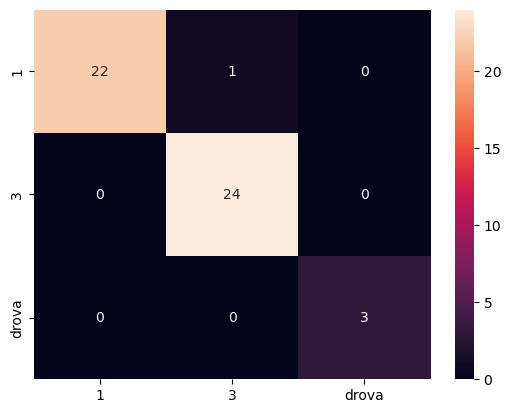

In [214]:
df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                  index = [i for i in labels],
                  columns = [i for i in labels])
sns.heatmap(df, annot=True)
None

The only mistake made by neural network 

In [218]:
for i in range(len(prepared_val_ds['train'])):
    pixel_values = prepared_val_ds['train'][i]['pixel_values']
    label = prepared_val_ds['train'][i]['labels']
    pred = model(pixel_values.unsqueeze(0)).logits.argmax().item()
    if label != pred:
        print(i)
        break

4


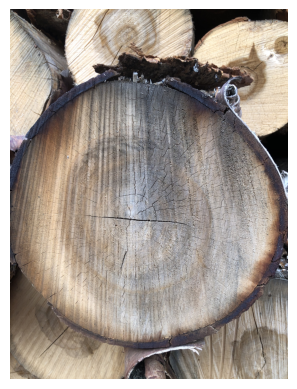

In [228]:
plt.imshow(val_ds['train'][4]['image'])
plt.axis('off')
None

## Predict

Image classification on test dataset without labels 

In [55]:
test_dataset = load_dataset("imagefolder", data_dir=TEST)
prepared_test_dataset = test_dataset.with_transform(transform)
prepared_test_dataset

Resolving data files:   0%|          | 0/249 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/melik/.cache/huggingface/datasets/imagefolder/default-7593e68df80c91ee/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 249
    })
})

In [95]:
idx2label = {i: label for i, label in enumerate(train_ds['train'].features['label'].names)}
idx2label[2] = 0

In [156]:
idx2label

{0: '1', 1: '3', 2: 0}

In [149]:
preds = []
for file in tqdm(sorted(os.listdir(TEST), key=lambda x: int(x[:x.find('.')]))):
    image = Image.open(TEST + file)
    image = image_processor(image, return_tensors="pt")
    pred = model(image['pixel_values']).logits
    preds.append(idx2label[pred.argmax().item()])

  0%|          | 0/249 [00:00<?, ?it/s]

In [150]:
with open('submission.csv','w', newline='\n') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'class'])
    for i, pred in enumerate(preds, start=1):
        writer.writerow([i, pred])

Timing of image classification on 1 image

In [54]:
%%timeit
model(prepared_test_dataset['train'][0]['pixel_values'].unsqueeze(0))

1.23 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Examples 

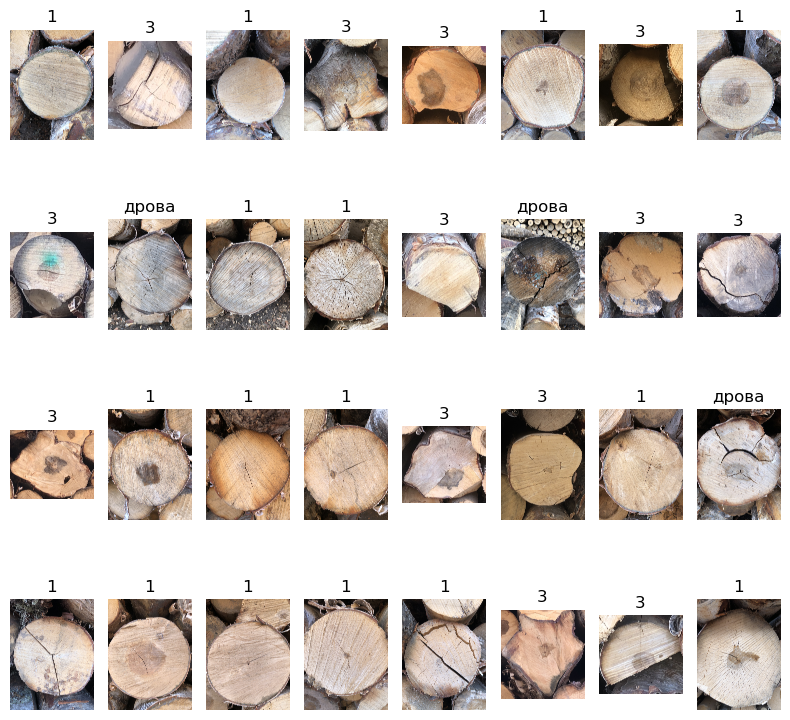

In [169]:
sorted_files = [TEST + file_name for file_name in sorted(os.listdir(TEST), key=lambda x: int(x[:x.find('.')]))]
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    img = Image.open(sorted_files[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('дрова' if preds[i] == 0 else preds[i])

plt.tight_layout()
plt.show()

# CNN

In [8]:
transforms = tfs.Compose([
    tfs.Resize(224), 
    tfs.CenterCrop(224), 
    tfs.ColorJitter(brightness=0.5, hue=0.5),
    tfs.ToTensor()])

In [9]:
dataset = ImageFolder(root=ROOT, transform=transforms)
idx = list(range(len(dataset)))
np.random.shuffle(idx)

In [10]:
train_idx = idx[:-50]
val_idx = idx[-50:]
train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds = torch.utils.data.Subset(dataset, val_idx)
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=True)
val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    shuffle=False)

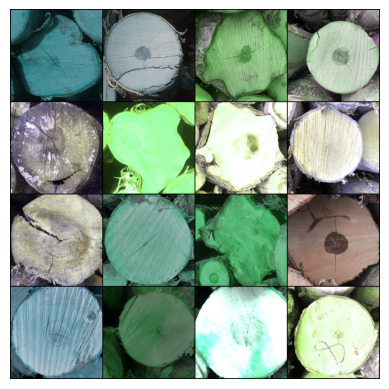

In [172]:
images, labels = next(iter(train_dl))
plt.imshow(make_grid(images, nrow=4).permute(2, 1, 0))
plt.axis('off')
None

In [236]:
model = regnet_x_16gf(weights=RegNet_X_16GF_Weights)
model.fc = nn.Sequential(
    nn.Linear(2048, 3, bias=True))

# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model.fc = nn.Linear(2048, 3, bias=True)

In [237]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        images, labels = batch
        pred = self.model(images)
        loss = nn.CrossEntropyLoss()(pred, labels)
        self.log(name='train_f1', value=multiclass_f1_score(pred, labels, num_classes=3, average="macro"))
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        pred = self.model(images)
        self.log(name='val_f1', value=multiclass_f1_score(pred, labels, num_classes=3, average="macro"))
    
    def test_step(self, batch, batch_idx):
        images = batch
        pred = self.model(images)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=LEARNING_RATE)
        return optimizer

In [240]:
cnn_clf = CNNClassifier(model)
# logger = WandbLogger(name="regnet_x_16_gf")

trainer = pl.Trainer( 
    max_epochs=1,
    log_every_n_steps=1,
    deterministic=True, 
    # logger=logger
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [241]:
trainer.fit(
    model=cnn_clf, 
    train_dataloaders=train_dl, 
    val_dataloaders=val_dl
)
# wandb.finish()


  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\melik\anaconda3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [223]:
images, _ = next(iter(val_dl))

In [242]:
cnn_clf.eval()
cnn_clf.model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [243]:
%%timeit
cnn_clf.model(images[0].unsqueeze(0))

110 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
